### Analysis on user engagement drop
Yammers is a social network for communicating with coworkers. Individuals share documents, updates, and ideas by posting them in groups. The analytics team found that there was a drop in weekly active users in August 2014. The aim of this analysis is to find out what may be the reason for dropped user engagement. 

#### Some possible reasons for dropped user engagement
1. Lower user acquisition
2. Lower customer retention
2. Technical issues specific to a device type or operating system
3. Issues with email campaign

These possibilities are examined using the following 3 datasets
<br>users: contains information about user account creation and activation
<br>events: contains information about engagement/activities (e.g. login, like message) on the platform
<br>emails: contains information about marketing emails sent to users

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Users data

In [2]:
users = pd.read_csv('yammer_users.csv')

In [3]:
users.head()

,user_id,created_at,company_id,language,activated_at,state
0,0.0,2013-01-01 20:59:39,5737.0,english,2013-01-01 21:01:07,active
1,1.0,2013-01-01 13:07:46,28.0,english,NaN,pending
2,2.0,2013-01-01 10:59:05,51.0,english,NaN,pending
3,3.0,2013-01-01 18:40:36,2800.0,german,2013-01-01 18:42:02,active
4,4.0,2013-01-01 14:37:51,5110.0,indian,2013-01-01 14:39:05,active


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19066 entries, 0 to 19065
Data columns (total 6 columns):
user_id         19066 non-null float64
created_at      19066 non-null object
company_id      19066 non-null float64
language        19066 non-null object
activated_at    9381 non-null object
state           19066 non-null object
dtypes: float64(2), object(4)
memory usage: 893.8+ KB


In [5]:
# change data type
users[['user_id', 'company_id']] = users[['user_id', 'company_id']].astype(int)
users[['created_at', 'activated_at']] = users[['created_at', 'activated_at']].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S')

In [6]:
users['created_at'] = users['created_at'].apply(lambda x: x.date())
users['created_at'] = pd.to_datetime(users['created_at'])

In [7]:
users['state'].value_counts()

pending    9685
active     9381
Name: state, dtype: int64

#### weekly new users 
first looked at weekly new users (number of unique users who created an account in a week) to see if the drop in user engagement has to do with lower user acquisition. 

In [8]:
# create a new column that rounds date to the date of beginning of a week
users['created_at_week'] = users['created_at'] - pd.to_timedelta(users['created_at'].dt.dayofweek, unit='d')

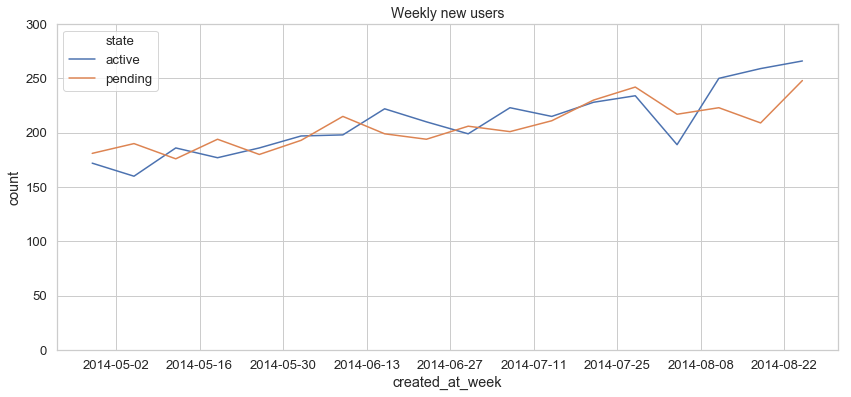

In [9]:
# get counts of weekly new users 
weekly_users = users.groupby(['state', 'created_at_week']).user_id.nunique()
weekly_users = weekly_users.reset_index(name='count') # count is same for all columns, only need one column
weekly_users = weekly_users[weekly_users['created_at_week']>'2014-4-27'] # only plot for may 14 onwards

sns.set(font_scale=1.2)
sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x='created_at_week', y='count', hue='state', data=weekly_users, ax=ax)
ax.set_title('Weekly new users', fontsize=14)
ax.set(ylim=(0, 300))
plt.show()

there is a dip in number of weekly new users, especially active new users at the beginning of August. however, in the following weeks, number of weekly new users went back up. The drop in user engagement throughout August is therefore unlikely to be only due to lower user acquisition.

### Events data

In [10]:
events1 = pd.read_csv('yammer_events_1.csv', index_col=0) # use first column as index 
events2 = pd.read_csv('yammer_events_2.csv', index_col=0)

events = pd.concat([events1, events2]) 

In [11]:
# merge events with signup date from users 
users_sub = users[['user_id', 'created_at']]
events = pd.merge(events, users_sub, on='user_id')

#### explore/clean features, create new features

In [12]:
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,created_at
0,10522.0,5/2/2014 11:02,engagement,login,Japan,dell inspiron notebook,3.0,2014-04-04
1,10522.0,5/2/2014 11:02,engagement,home_page,Japan,dell inspiron notebook,3.0,2014-04-04
2,10522.0,5/2/2014 11:03,engagement,like_message,Japan,dell inspiron notebook,3.0,2014-04-04
3,10522.0,5/2/2014 11:04,engagement,view_inbox,Japan,dell inspiron notebook,3.0,2014-04-04
4,10522.0,5/2/2014 11:03,engagement,search_run,Japan,dell inspiron notebook,3.0,2014-04-04


In [13]:
events.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 340832 entries, 0 to 340831
Data columns (total 8 columns):
user_id        340832 non-null float64
occurred_at    340832 non-null object
event_type     340832 non-null object
event_name     340832 non-null object
location       340832 non-null object
device         340832 non-null object
user_type      325255 non-null float64
created_at     340832 non-null datetime64[ns]
dtypes: datetime64[ns](1), float64(2), object(5)
memory usage: 23.4+ MB


In [14]:
# check and drop missing values
events.isnull().sum()

user_id            0
occurred_at        0
event_type         0
event_name         0
location           0
device             0
user_type      15577
created_at         0
dtype: int64

In [15]:
events.dropna(axis=0, how='any', inplace=True)

In [16]:
# change label for user_type
user_map = {1: 'type 1', 2: 'type 2', 3: 'type 3'}
events['user_type'] = events['user_type'].map(user_map)

In [17]:
# check and drop duplicated rows
events.duplicated().sum()

6677

In [18]:
events = events.drop_duplicates()

In [19]:
events['event_type'].value_counts()

engagement     314898
signup_flow      3680
Name: event_type, dtype: int64

In [20]:
events['event_name'].value_counts()

home_page                 92796
like_message              58766
view_inbox                55511
login                     38609
send_message              32971
search_autocomplete       15890
search_run                10711
complete_signup            3680
search_click_result_2      1473
search_click_result_1      1388
search_click_result_4      1246
search_click_result_3      1119
search_click_result_5       956
search_click_result_6       799
search_click_result_9       777
search_click_result_7       703
search_click_result_8       681
search_click_result_10      502
Name: event_name, dtype: int64

include only event of type 'engagement', which is the focus of this analysis and of name 'login' - all activities start with login

In [21]:
events = events[(events['event_type']=='engagement')&(events['event_name']=='login')]

In [22]:
# change data type for some columns
events['user_id'] = events['user_id'].astype(int)
events['occurred_at'] = pd.to_datetime(events['occurred_at'])

In [23]:
# keep only the date in datetime objects
events['occurred_at'] = events['occurred_at'].apply(lambda x: x.date())
events['occurred_at'] = pd.to_datetime(events['occurred_at'])

create a new column that rounds event date to date of beginning of a week: occurred_at_week

In [24]:
events['occurred_at_week'] = events['occurred_at'] - pd.to_timedelta(events['occurred_at'].dt.dayofweek, unit='d')

create a new feature weeks_since_signup (<1 week, 1 week, 2 weeks, ..., >=9 weeks): how long has a user signed up at each week.
<br>will be used to look at if the drop in engagement has to do with use of old or new users

In [1]:
def weeks_elasped(days):
    if days<7:
        return 'less than 1 week'
    elif days>=7 and days<14:
        return '1 week'
    elif days>=14 and days<21:
        return '2 weeks'
    elif days>=21 and days<28:
        return '3 weeks'
    elif days>=28 and days<35:
        return '4 weeks'
    elif days>=35 and days<42:
        return '5 weeks'
    elif days>=42 and days<49:
        return '6 weeks'
    elif days>=49 and days<56:
        return '7 weeks'
    elif days>=56 and days<63:
        return '8 weeks'
    else:
        return '9 weeks or more'

In [26]:
events['days_since_signup'] = (events['occurred_at_week'] - events['created_at']).dt.days
events['weeks_since_signup'] = events['days_since_signup'].apply(weeks_elasped)

In [27]:
events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,created_at,occurred_at_week,days_since_signup,weeks_since_signup
0,10522,2014-05-02,engagement,login,Japan,dell inspiron notebook,type 3,2014-04-04,2014-04-28,24,3 weeks
6,10522,2014-06-13,engagement,login,Japan,lenovo thinkpad,type 3,2014-04-04,2014-06-09,66,9 weeks or more
18,10522,2014-06-13,engagement,login,Japan,iphone 5s,type 3,2014-04-04,2014-06-09,66,9 weeks or more
42,10522,2014-06-17,engagement,login,Japan,dell inspiron notebook,type 3,2014-04-04,2014-06-16,73,9 weeks or more
44,10522,2014-06-17,engagement,login,Japan,dell inspiron notebook,type 3,2014-04-04,2014-06-16,73,9 weeks or more


In [28]:
events['device'].value_counts()

macbook pro               6804
lenovo thinkpad           4419
macbook air               3133
iphone 5                  3063
dell inspiron notebook    2346
samsung galaxy s4         2256
nexus 5                   1893
iphone 5s                 1839
dell inspiron desktop     1192
iphone 4s                 1151
asus chromebook           1119
ipad air                  1111
acer aspire notebook      1080
hp pavilion desktop       1061
nexus 7                    822
nokia lumia 635            689
ipad mini                  660
acer aspire desktop        626
nexus 10                   605
htc one                    526
mac mini                   520
kindle fire                485
windows surface            409
samsung galaxy note        334
amazon fire phone          248
samsumg galaxy tablet      218
Name: device, dtype: int64

create a new feature device_type with 3 categories: computer, phone, or tablet

In [29]:
computers = ['dell inspiron desktop', 'hp pavilion desktop', 'acer aspire desktop', 'macbook pro', 'lenovo thinkpad',
             'macbook air', 'dell inspiron notebook', 'asus chromebook', 'acer aspire notebook', 'mac mini']
phones = ['iphone 5', 'samsung galaxy s4', 'nexus 5', 'iphone 5s', 'iphone 4s', 'nokia lumia 635',
         'htc one', 'samsung galaxy note', 'amazon fire phone']
tablets = ['ipad air', 'ipad mini', 'kindle fire', 'samsung galaxy tablet', 'windows surface', 'nexus 7', 'nexus 10']

def device_type(string):
    if string in computers:
        return 'computer'
    elif string in phones:
        return 'phone'
    else:
        return 'tablet'

# create device_type variable
events['device_type'] = events['device'].apply(device_type)

have a dataframe for phone users only, create a column for operating system: android, iOS, windows

In [30]:
phone_events = events[events['device_type']=='phone']

android = ['samsung galaxy s4', 'nexus 5', 'htc one', 'samsung galaxy note', 'amazon fire phone']
ios = ['iphone 5', 'iphone 5s', 'iphone 4s']
windows = ['nokia lumia 635']

def phone_os(string):
    if string in android:
        return 'android'
    elif string in ios:
        return 'ios'
    else:
        return 'windows'

phone_events['os'] = phone_events['device'].apply(phone_os)

C:\Users\nalgn\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [31]:
phone_events.head()

,user_id,occurred_at,event_type,event_name,location,device,user_type,created_at,occurred_at_week,days_since_signup,weeks_since_signup,device_type,os
18,10522,2014-06-13,engagement,login,Japan,iphone 5s,type 3,2014-04-04,2014-06-09,66,9 weeks or more,phone,ios
54,10522,2014-06-21,engagement,login,Japan,iphone 5s,type 3,2014-04-04,2014-06-16,73,9 weeks or more,phone,ios
58,10612,2014-05-01,engagement,login,Netherlands,iphone 5,type 1,2014-04-07,2014-04-28,21,3 weeks,phone,ios
70,10612,2014-05-19,engagement,login,Netherlands,iphone 5,type 1,2014-04-07,2014-05-19,42,6 weeks,phone,ios
82,10612,2014-05-19,engagement,login,Netherlands,iphone 5,type 1,2014-04-07,2014-05-19,42,6 weeks,phone,ios


#### Visualization of weekly active users overall and broken down by different features

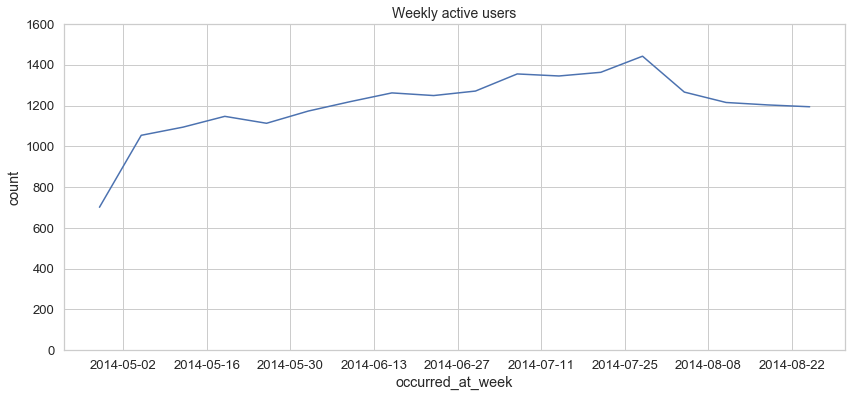

In [32]:
# weekly active users overall
weekly_users = events.groupby('occurred_at_week').user_id.nunique()
weekly_users = weekly_users.reset_index(name='count')

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x='occurred_at_week', y='count', data=weekly_users, ax=ax)
ax.set_title('Weekly active users', fontsize=14)
ax.set(ylim=(0, 1600))
plt.show()

weekly active users dropped throughout August, particularly large dip at beginning of August.

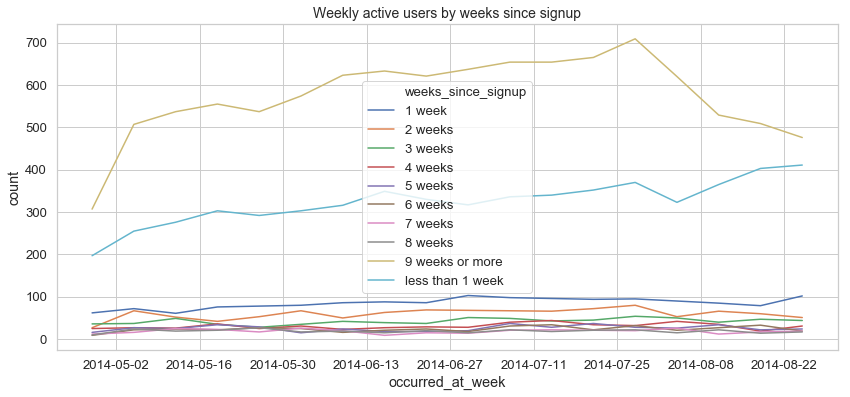

In [33]:
# weekly active users broken down by weeks since signup
weekly_users_signup = events.groupby(['occurred_at_week', 'weeks_since_signup']).user_id.nunique()
weekly_users_signup = weekly_users_signup.reset_index(name='count')

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x='occurred_at_week', y='count', hue='weeks_since_signup', data=weekly_users_signup, ax=ax)
ax.set_title('Weekly active users by weeks since signup', fontsize=14)
plt.show()

engagement dropped in Aug among users who had signed up for 9 weeks or more. engagement of other users did not drop and in fact more new users (<1 week) used the platform in August. these suggest that retention of old users needs to be worked on.

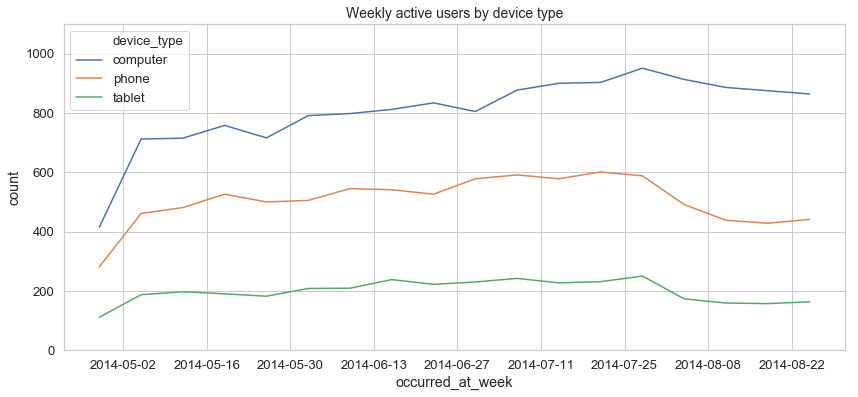

In [34]:
# weekly active users broken down by device type
weekly_users_devicetype = events.groupby(['device_type', 'occurred_at_week']).user_id.nunique()
weekly_users_devicetype = weekly_users_devicetype.reset_index(name='count')

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x='occurred_at_week', y='count', hue='device_type', data=weekly_users_devicetype, ax=ax)
ax.set_title('Weekly active users by device type', fontsize=14)
ax.set(ylim=(0, 1100))
plt.show()

engagement dropped among all device types but was most prominent among phone users. next, break down phone category to different operating systems to see if the problem can be narrowed down to a particular os.

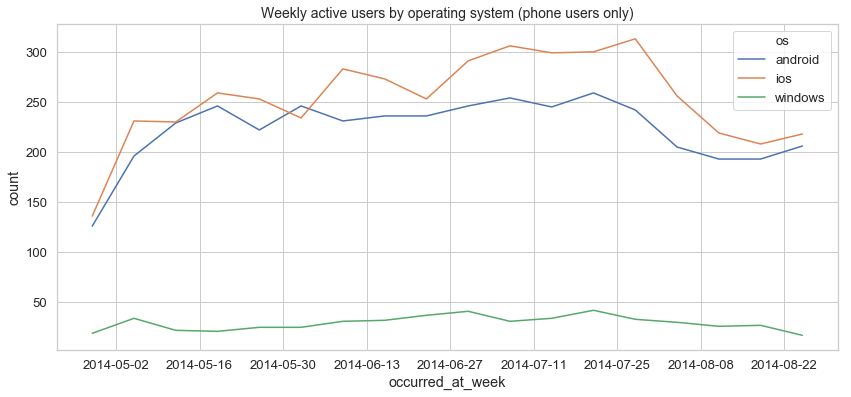

In [35]:
weekly_phone_users = phone_events.groupby(['os', 'occurred_at_week']).user_id.nunique()
weekly_phone_users = weekly_phone_users.reset_index(name='count')

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x='occurred_at_week', y='count', hue='os', data=weekly_phone_users, ax=ax)
ax.set_title('Weekly active users by operating system (phone users only)', fontsize=14)
plt.show()

user engagement dropped for both android and ios systems.

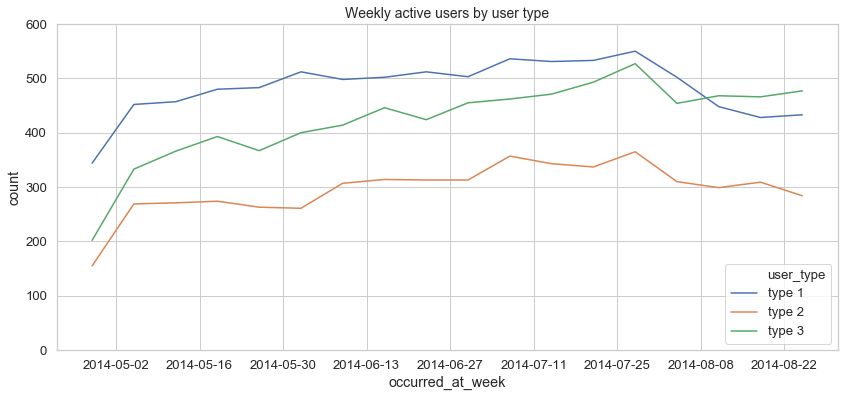

In [36]:
# weekly active users broken down by user type
weekly_users_usertype = events.groupby(['occurred_at_week', 'user_type']).user_id.nunique()
weekly_users_usertype = weekly_users_usertype.reset_index(name='count')

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x='occurred_at_week', y='count', hue='user_type', data=weekly_users_usertype, ax=ax)
ax.set_title('Weekly active users by user type', fontsize=14)
ax.set(ylim=(0, 600))
plt.show()

the drop in user engagement occurred across different types of users, although for type 3 users, engagement went back up a little later in August.

### Emails data
look at if email marketing was effective in directing traffic back to the platform

In [37]:
emails = pd.read_csv('yammer_emails.csv')

In [38]:
emails.head()

,user_id,occurred_at,action,user_type
0,0,5/6/2014 9:30,sent_weekly_digest,1
1,0,5/13/2014 9:30,sent_weekly_digest,1
2,0,5/20/2014 9:30,sent_weekly_digest,1
3,0,5/27/2014 9:30,sent_weekly_digest,1
4,0,6/3/2014 9:30,sent_weekly_digest,1


In [39]:
emails.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90389 entries, 0 to 90388
Data columns (total 4 columns):
user_id        90389 non-null int64
occurred_at    90389 non-null object
action         90389 non-null object
user_type      90389 non-null int64
dtypes: int64(2), object(2)
memory usage: 2.8+ MB


In [40]:
# change label for user_type
user_map = {1: 'type 1', 2: 'type 2', 3: 'type 3'}
emails['user_type'] = emails['user_type'].map(user_map)

In [41]:
# keep only date of occurred_at
emails['occurred_at'] = pd.to_datetime(emails['occurred_at'])
emails['occurred_at'] = pd.to_datetime(emails['occurred_at'].apply(lambda x: x.date()))

In [42]:
emails['action'].value_counts()

sent_weekly_digest         57267
email_open                 20459
email_clickthrough          9010
sent_reengagement_email     3653
Name: action, dtype: int64

two types of emails are sent to users: weekly digest and reengagement email

#### manipulate email actions to prepare for visualization

In [43]:
# create dummy variables for action
email_dummies = pd.get_dummies(emails['action'])
emails = pd.concat([emails, email_dummies], axis=1)

In [44]:
emails.head()

,user_id,occurred_at,action,user_type,email_clickthrough,email_open,sent_reengagement_email,sent_weekly_digest
0,0,2014-05-06,sent_weekly_digest,type 1,0,0,0,1
1,0,2014-05-13,sent_weekly_digest,type 1,0,0,0,1
2,0,2014-05-20,sent_weekly_digest,type 1,0,0,0,1
3,0,2014-05-27,sent_weekly_digest,type 1,0,0,0,1
4,0,2014-06-03,sent_weekly_digest,type 1,0,0,0,1


In [45]:
# for each user and date, code if a weekly digest/reengagement email is sent, and if it is opened/clicked through
email_actions = emails.groupby(['user_id']).resample('D', on='occurred_at').sum() # resample to days
email_actions.drop(['user_id'], axis=1, inplace=True)
email_actions.reset_index(inplace=True)

cols = ['email_clickthrough', 'email_open', 'sent_reengagement_email', 'sent_weekly_digest']
email_actions = email_actions[(email_actions[cols]!=0).any(axis=1)] # remove days where no email was sent - all cols 0
email_actions.reset_index(drop=True, inplace=True)

In [46]:
# round email date to date of beginning of a week
email_actions['occurred_at_week'] = email_actions['occurred_at'] - pd.to_timedelta(email_actions['occurred_at'].dt.dayofweek, unit='d')

In [47]:
# change 'sent_reengagement_email' and sent_weekly_digest columns to one single column 'email_type'
email_actions['email_type'] = np.where(email_actions['sent_weekly_digest']==0, 'reengagement', 'weekly digest')
email_actions.drop(['sent_reengagement_email', 'sent_weekly_digest'], axis=1, inplace=True)
email_actions.head()

,user_id,occurred_at,email_clickthrough,email_open,occurred_at_week,email_type
0,0,2014-05-06,0,0,2014-05-05,weekly digest
1,0,2014-05-13,0,0,2014-05-12,weekly digest
2,0,2014-05-20,0,0,2014-05-19,weekly digest
3,0,2014-05-27,0,0,2014-05-26,weekly digest
4,0,2014-06-03,0,1,2014-06-02,weekly digest


#### visualize number of weekly emails sent to users

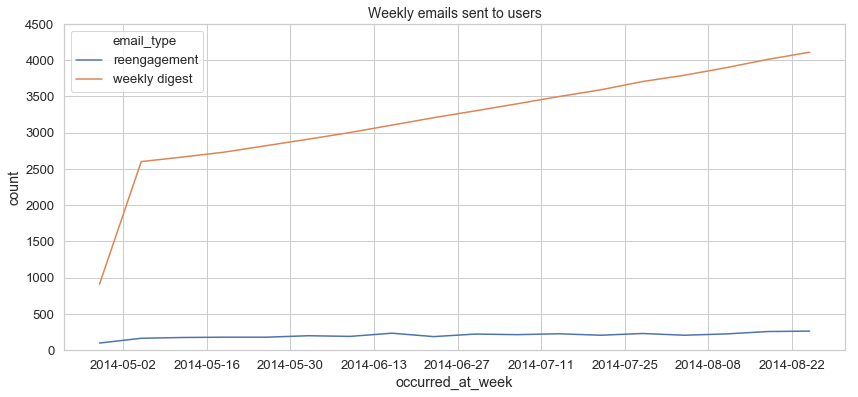

In [48]:
emails_count = email_actions.groupby(['email_type', 'occurred_at_week']).user_id.count()
emails_count = emails_count.reset_index(name='count')

fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x='occurred_at_week', y='count', hue='email_type', data=emails_count, ax=ax)
ax.set_title('Weekly emails sent to users', fontsize=14)
ax.set(ylim=(0, 4500))
plt.show()

number of weekly digest emails sent to users increases steadily, which is good, there's no issue with email sending. number of reengagement emails sent is constant across time; very few reengagement emails are sent though!

#### visualize email open rates
num emails opened/num emails sent

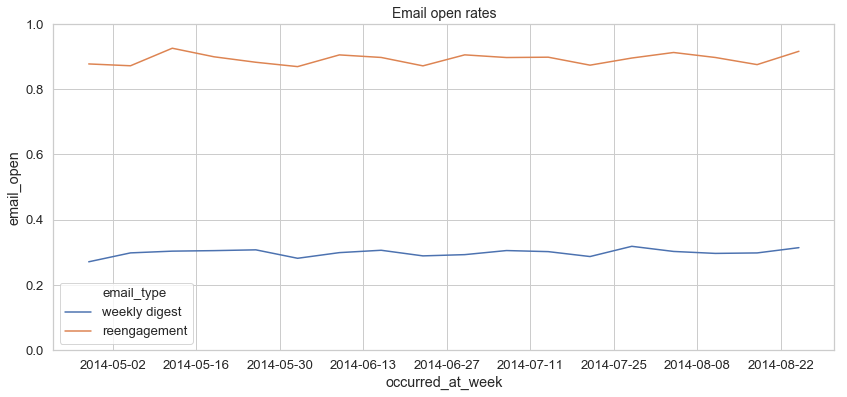

In [49]:
# email open rates
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x='occurred_at_week', y='email_open', hue='email_type', data=email_actions, ci=None, ax=ax)
ax.set_title('Email open rates', fontsize=14)
ax.set(ylim=(0, 1))
plt.show()

email open rates don't change much as a function of time for both weekly digest and reengagement emails. the open rates for reengagement email is much much higher than weekly digest. 

#### visualize email clickthrough rates
num emails clicked through/num mails sent

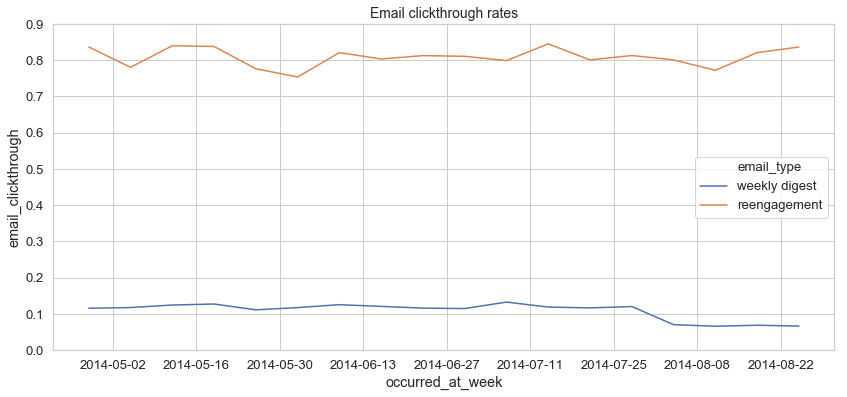

In [50]:
fig, ax = plt.subplots(figsize=(14, 6))
sns.lineplot(x='occurred_at_week', y='email_clickthrough', hue='email_type', data=email_actions, ci=None, ax=ax)
ax.set_title('Email clickthrough rates', fontsize=14)
ax.set(ylim=(0, 0.9))
plt.show()

drop in weekly digest clickthrough rates in August. this leads to less traffic directed back to the platform and therefore lower engagement.
<br>clickthrough rates for reengagement emails are much much higher than weekly digest emails!

### Overall recommendations
#### It appears that the drop in weekly active users has to do with app use on phones and weekly digest emails. 
#### 1. Follow up with product/software team to see if there are any technical problems with mobile apps, which appear to occur for both android and iOS systems. Also need to check if links in weekly digest emails are broken.
#### 2. Need to explore ways to reengage/retain old users.
#### 3. Few reengagement emails are sent to users currently. Given how effective reengagement emails are in directing traffic to the platform, the team should investigate the ROI of sending more reengagement emails to old users. 